In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pqm import pqm_chi2, pqm_pvalue
from scipy.stats import norm, chi2, uniform, kstest

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rc("text", usetex=True)

Create a distribution, and sample from it twice

In [2]:
class TimeSeriesModel:
    def __init__(self, a = 0., sigma=1., nt=100):
        self.t = np.linspace(0, 10, nt)
        self.a = a
        self.sigma = sigma
        
    def generate_samples(self, num_samples):
        # Generate samples from each component
        y = self.a * np.cos(self.t) + self.sigma * np.random.randn(num_samples, len(self.t))
        return y


In [3]:
num_repeats = 20
gmm_null = TimeSeriesModel(a = 0)

amps = np.logspace(-2, 0, 20)
chisqs_mean = np.zeros_like(amps)
chisqs_std = np.zeros_like(amps)

for i, a in enumerate(amps):
    gmm = TimeSeriesModel(a = a)
    null_samples = gmm_null.generate_samples(num_samples=5000)
    y_samples = gmm.generate_samples(num_samples=5000)
    zs = []
    dof_array = []
    for _ in range(num_repeats):
        z, dof = pqm_chi2(y_samples, null_samples)
        zs.append(z)
        dof_array.append(dof)
        
    chisqs_mean[i] = np.mean(zs)
    chisqs_std[i] = np.std(zs)
    print(a, chisqs_mean[i], chisqs_std[i], np.unique(dof_array))

0.01 98.60501969852818 11.357056275297845 [99]
0.012742749857031334 95.77847319166933 16.010775574058655 [99]
0.016237767391887217 98.72499292347838 9.320920096441238 [99]
0.0206913808111479 103.70213406793744 11.067037847527047 [99]
0.026366508987303583 99.46922105819611 17.195813622494878 [99]
0.03359818286283781 108.7957492293604 12.767188925448211 [99]
0.04281332398719394 109.20380298036346 17.83874783782844 [99]
0.0545559478116852 116.17132066797826 13.992304142950186 [99]
0.06951927961775606 126.59201076304325 16.86183067379209 [99]
0.08858667904100823 156.56839110030123 18.02757583060377 [99]


/Users/sammysharief/anaconda3/envs/tarp_project/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


0.11288378916846889 inf nan [99]
0.14384498882876628 inf nan [99]
0.18329807108324356 inf nan [99]
0.23357214690901212 inf nan [99]
0.29763514416313175 inf nan [99]
0.37926901907322497 inf nan [99]
0.4832930238571752 inf nan [99]
0.615848211066026 inf nan [99]
0.7847599703514611 inf nan [99]
1.0 inf nan [99]


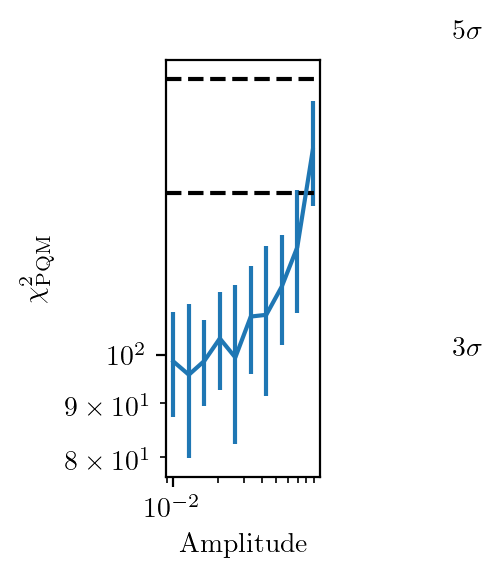

In [4]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.errorbar(amps, chisqs_mean, yerr=chisqs_std)
ax.axhline(chi2.ppf(0.997300203936740, 99), ls='--', color='k')
ax.axhline(chi2.ppf(0.999999426696856, 99), ls='--', color='k')
ax.text(0.8, 100, r'$3 \sigma$')
ax.text(0.8, 200, r'$5 \sigma$')
ax.set_xlabel('Amplitude')
ax.set_ylabel('$\chi^2_{\mathrm{ PQM}}$')
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()
plt.show()

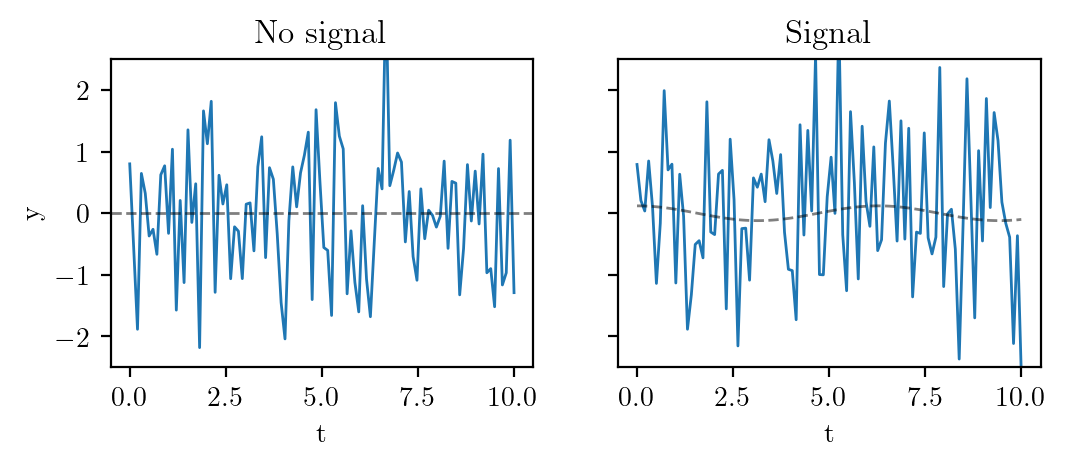

In [5]:
gmm = TimeSeriesModel(a = 0.12)
gmm_null = TimeSeriesModel(a = 0)
x_samples = gmm.generate_samples(num_samples=2)
null_samples = gmm_null.generate_samples(num_samples=2)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(6, 2), sharex=True, sharey=True)
axs[0].plot(gmm.t, null_samples[0], lw=1)
axs[0].axhline(0, color='k', lw=1, ls='--', alpha=0.5)
axs[0].set_ylim([-2.5, 2.5])
axs[0].set_xlabel('t')
axs[0].set_ylabel('y')
axs[0].set_title('No signal')

axs[1].plot(gmm.t, x_samples[0], lw=1)
axs[1].plot(gmm.t, gmm.a * np.cos(gmm.t), color='k', lw=1, ls='--', alpha=0.5)
axs[1].set_ylim([-2.5, 2.5])
axs[1].set_title('Signal')
axs[1].set_xlabel('t')

plt.show()

# Using p-value

In [6]:
num_repeats = 20
gmm_null = TimeSeriesModel(a = 0)

amps = np.logspace(-2, 0, 20)
p_val_mean = np.zeros_like(amps)
p_val_std = np.zeros_like(amps)

for i, a in enumerate(amps):
    gmm = TimeSeriesModel(a = a)
    null_samples = gmm_null.generate_samples(num_samples=5000)
    y_samples = gmm.generate_samples(num_samples=5000)
    p_val = []
    for _ in range(num_repeats):
        pval = pqm_pvalue(y_samples, null_samples)
        p_val.append(pval)
    if np.mean(p_val) > 0.01:
        print("Do not reject the null hypothesis")
    else:
        print("Reject the null hypothesis")
    p_val_mean[i] = np.mean(p_val)
    p_val_std[i] = np.std(p_val)
    print(a, np.mean(p_val), np.std(p_val))

Do not reject the null hypothesis
0.01 0.49211669429134314 0.31654762531608177
Do not reject the null hypothesis
0.012742749857031334 0.5158488150146399 0.31365049802575
Do not reject the null hypothesis
0.016237767391887217 0.33762763997315826 0.2323753861288948
Do not reject the null hypothesis
0.0206913808111479 0.4674045513459295 0.31449878573995627
Do not reject the null hypothesis
0.026366508987303583 0.3385872353709046 0.26828688677603485
Do not reject the null hypothesis
0.03359818286283781 0.3805421264660683 0.27475976031627986
Do not reject the null hypothesis
0.04281332398719394 0.3929957776816092 0.2628325198352732
Do not reject the null hypothesis
0.0545559478116852 0.10027940338184764 0.14041094077903843
Do not reject the null hypothesis
0.06951927961775606 0.0808740740522712 0.12223606874634785
Reject the null hypothesis
0.08858667904100823 0.006225861120284464 0.015652769586330214
Reject the null hypothesis
0.11288378916846889 0.00025665631186114765 0.000714000408354389

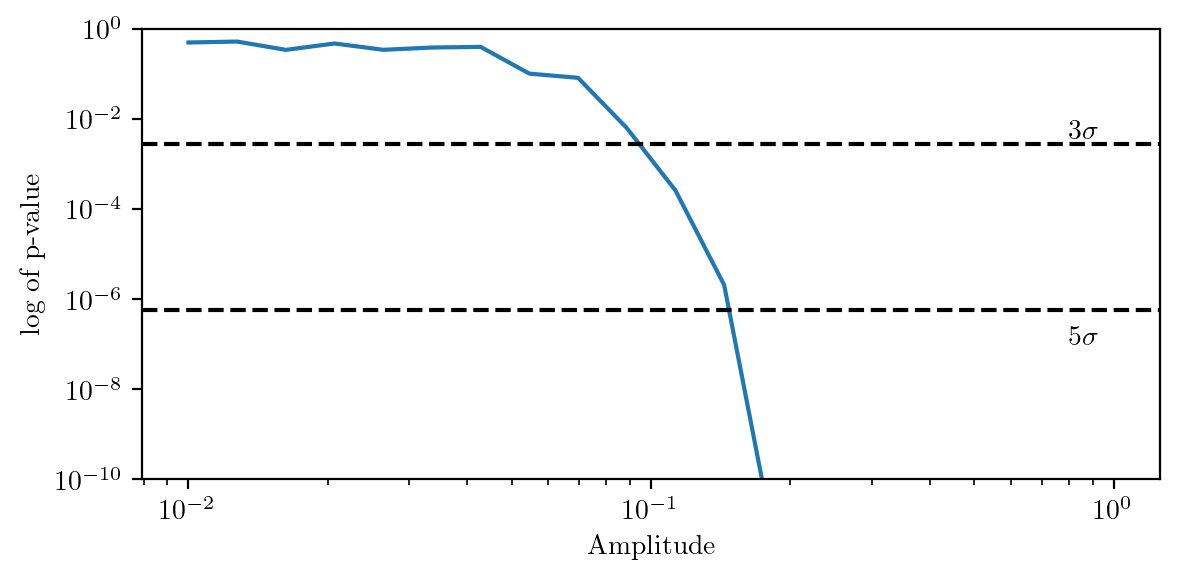

In [7]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(amps, p_val_mean)
ax.axhline(1 - 0.997300203936740, ls='--', color='k')  # 3 sigma equivalent p-value
ax.axhline(1 - 0.999999426696856, ls='--', color='k')  # 5 sigma equivalent p-value
ax.text(0.8, 0.01, r'$3 \sigma$', verticalalignment='top')
ax.text(0.8, 0.0000001, r'$5 \sigma$')
ax.set_xlabel('Amplitude')
ax.set_ylabel('log of p-value')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-10, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()
